In [1]:
# Import Modules
# Import Python libraries:
import matplotlib.pyplot as plt # For plotting
import numpy as np              # NumPy, for working with arrays/tensors 
import time                     # For measuring time
import random                   # Python's random library
import pickle
# PyTorch libraries:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from pytorch3d.structures import Meshes
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchinfo import summary
from PIL import Image
import binary_rw


# Add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

In [2]:
# Import CUDA

if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!


In [3]:
train_img_file = "/home/mehmet/Desktop/DL/train_img_mini"
train_model_file = "/home/mehmet/Desktop/DL/train_vox_mini"
test_img_file = "/home/mehmet/Desktop/DL/test_img_mini"
test_model_file = "/home/mehmet/Desktop/DL/test_vox_mini"

Dataset Implementation

In [4]:
class R2N2_Dataset():
    def __init__(self, img_file, model_file):
        
        self.img_file = img_file
        self.model_file = model_file
        self.img_list, self.model_list = self.get_list()
        self.convert_tensor = transforms.Compose([transforms.ToTensor()])
        
        
    def get_list(self):
        img_paths = self.load_data_path(self.img_file)
        model_paths = self.load_data_path(self.model_file)
        
        return img_paths, model_paths
    
    def load_data_path(self, file):
        
        with open(file, "rb") as f:
            data_paths = pickle.load(f)
        
        return data_paths
    
    def __len__(self):
        return len(self.model_list)
    
    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        img = Image.open(img_path)
        img = np.array(img)
        img_tensor = self.convert_tensor(img[:,:,:3])
        img_tensor = img_tensor
        
        with open(self.model_list[idx], 'rb') as f:
            model_meta = binary_rw.read_as_3d_array(f)
            model = np.array(model_meta.data, dtype=float)
            model = np.float32(model)
        
        model_tensor = self.convert_tensor(model).unsqueeze(dim=0)
        
        return img_tensor, model_tensor

Dataloader Implementation

In [5]:
dataset = R2N2_Dataset(train_img_file, train_model_file)
test_dataset = R2N2_Dataset(test_img_file, test_model_file)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=80, shuffle=True, num_workers=10)

In [67]:
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=80, shuffle=True, num_workers=10)
test_data = enumerate(test_dataloader)
i, batch = next(test_data)
test_image, test_label = batch

Loss Function Implementation

In [7]:
class Modified_Binary_Cross_Entropy_Loss(nn.Module):
    def __init__(self):
        super(Modified_Binary_Cross_Entropy_Loss, self).__init__()
        self.r = 32
        self.bce = nn.BCELoss()
    
    def forward(self, output:torch.Tensor, target:torch.Tensor):
        batch_size = output.shape[0]
        out_flat = output.reshape((batch_size, -1))
        target_flat = target.reshape((batch_size, -1))
        
        loss = self.bce(out_flat, target_flat)
        
        return loss.sum()

Image Encoder Implementation

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Shape_Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        # Define 3 convolution layer of Resnet50 which is already trained.
        self.resnet_imp()
        
        # Define 3 more convolutional layer with normalization layers
        self.conv1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, bias=False)
        self.conv1_bn = nn.BatchNorm2d(num_features = 512)
        
        self.conv2 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1, bias=False)
        self.conv2_bn = nn.BatchNorm2d(num_features = 256)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, bias=False)
        self.conv3_bn = nn.BatchNorm2d(num_features=256)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.flt = torch.nn.Flatten()
        
    def forward(self, x):
        
        batch_size = x.shape[0]
        # Resnet pretrained model
        x = self.resnet_model(x)
        # First convolutional layer
        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = F.relu(x)
        # Second convolutional layer with pooling
        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = F.relu(x)
        x = self.maxpool1(x)
        # Third convolutional layer with pooling
        x = self.conv3(x)
        x = self.conv3_bn(x)
        x = F.relu(x)
        x = self.maxpool2(x)
        
        return x
    
    def resnet_imp(self):
        
        OrigResNet50 = self.resnet_load()
        
        # Freeze Resnet50 parameters
        for parameter in OrigResNet50.parameters():
            parameter.requires_grad = False
            
        self.resnet_model = nn.Sequential(*list(OrigResNet50.children())[:6])
    
    def resnet_load(self):
        OrigResNet50 = None
        repo = 'pytorch/vision'
        OrigResNet50 = torch.hub.load(repo, 'resnet50', pretrained=True).to(device)
        
        return OrigResNet50

LSTM Shape Encoder

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class FC_Layer(torch.nn.Module):
    
    def __init__(self):

        super().__init__()
        self.FC1 = nn.Linear(4096,2048)
        

    def forward(self, X):

        #B, input_size = X.shape
        
        X = torch.flatten(X, start_dim=1)
        X = self.FC1(X)
        X = F.relu(X)
        
        return X

Shape Decoder Implementation

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Shape_Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)       
        self.conv1 = None
        self.conv1_bn = None
        self.conv2 = None
        self.conv2_bn = None
        self.conv3 = None
        self.conv3_bn = None
        self.conv4 = None
        self.conv4_bn = None
        self.conv5 = None
        
        
        self.conv1 = nn.ConvTranspose3d(in_channels= 6144, out_channels=512, kernel_size=4, stride=2, padding=1)
        self.conv1_bn = nn.BatchNorm3d(num_features=512)
        
        self.conv2 = nn.ConvTranspose3d(in_channels= 512, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.conv2_bn = nn.BatchNorm3d(num_features=128)
        
        self.conv3 = nn.ConvTranspose3d(in_channels= 128, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv3_bn = nn.BatchNorm3d(num_features=32)
        
        self.conv4 = nn.ConvTranspose3d(in_channels= 32, out_channels=8, kernel_size=4, stride=2, padding=1)
        self.conv4_bn = nn.BatchNorm3d(num_features= 8)
        
        self.conv5 = nn.ConvTranspose3d(in_channels= 8, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = F.relu(x)
        
        x = self.conv3(x)
        x = self.conv3_bn(x)
        x = F.relu(x)
        
        x = self.conv4(x)
        x = self.conv4_bn(x)
        x = F.relu(x)
        
        x = self.conv5(x)
        x = F.sigmoid(x)
        
        return x    

Networks are merged. Data which is came from Encoder is flattened. 

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Merged_Network(nn.Module):
    def __init__(self, device=device):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.shape_encoder = Shape_Encoder().to(device)
        self.lstm_concept = FC_Layer().to(device)
        self.shape_decoder = Shape_Decoder().to(device)
        
    def forward(self, x):
        
        batch_size = x.shape[0]
        
        x = self.shape_encoder(x)
        y = self.lstm_concept(x.view((batch_size),-1))
        y = y.unsqueeze(dim=2).unsqueeze(dim=3).unsqueeze(dim=4)
        x = x.view((batch_size,-1,1,1)).unsqueeze(dim=4)
        # z is concatnated version of x and y
        z = torch.cat((x,y),1)
        z = self.shape_decoder(z)
        
        return z

Model Initialized

In [12]:
network = Merged_Network().to(device)
#summary(network, input_size=[120, 3, 137, 137])

Using cache found in /home/mehmet/.cache/torch/hub/pytorch_vision_main
/home/mehmet/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/mehmet/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
summary(network, input_size=[80,3,127,127])

Layer (type:depth-idx)                             Output Shape              Param #
Merged_Network                                     [80, 1, 32, 32, 32]       --
├─Shape_Encoder: 1-1                               [80, 256, 4, 4]           --
│    └─Sequential: 2-1                             [80, 512, 16, 16]         --
│    │    └─Conv2d: 3-1                            [80, 64, 64, 64]          (9,408)
│    │    └─BatchNorm2d: 3-2                       [80, 64, 64, 64]          (128)
│    │    └─ReLU: 3-3                              [80, 64, 64, 64]          --
│    │    └─MaxPool2d: 3-4                         [80, 64, 32, 32]          --
│    │    └─Sequential: 3-5                        [80, 256, 32, 32]         (215,808)
│    │    └─Sequential: 3-6                        [80, 512, 16, 16]         (1,219,584)
│    └─Flatten: 2-2                                --                        --
│    └─Conv2d: 2-3                                 [80, 512, 16, 16]         2,359,296
│   

In [13]:
def train(model, criterion, optimizer, epochs, dataloader, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the loss history.
  """
  loss_history = []

  for epoch in range(epochs):
    print(f'epoch - {epoch}')
    for i, data in enumerate(dataloader, 0):   
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      # Calculate loss
      loss = criterion(outputs.to(device), labels)

      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      loss_history.append(loss.item())
    
    if verbose: 
      print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return model, loss_history

Training Session

In [14]:
loss = Modified_Binary_Cross_Entropy_Loss()
optim = torch.optim.Adam(network.parameters(), lr=0.002)

train_model = True

if train_model:
    model, loss_history = train(network, loss, optim, 20, dataloader)
else:
    model = torch.load("train.pth")

epoch - 0


/home/mehmet/.local/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0 / 20: avg. loss of last 5 iterations 0.21755255460739137
epoch - 1
Epoch 1 / 20: avg. loss of last 5 iterations 0.20784071683883668
epoch - 2
Epoch 2 / 20: avg. loss of last 5 iterations 0.18580405712127684
epoch - 3
Epoch 3 / 20: avg. loss of last 5 iterations 0.17492730915546417
epoch - 4
Epoch 4 / 20: avg. loss of last 5 iterations 0.16794184148311614
epoch - 5
Epoch 5 / 20: avg. loss of last 5 iterations 0.14620032608509065
epoch - 6
Epoch 6 / 20: avg. loss of last 5 iterations 0.14707332253456115
epoch - 7
Epoch 7 / 20: avg. loss of last 5 iterations 0.12094638496637344
epoch - 8
Epoch 8 / 20: avg. loss of last 5 iterations 0.11482693105936051
epoch - 9
Epoch 9 / 20: avg. loss of last 5 iterations 0.10791618525981903
epoch - 10
Epoch 10 / 20: avg. loss of last 5 iterations 0.08913307636976242
epoch - 11
Epoch 11 / 20: avg. loss of last 5 iterations 0.08188682347536087
epoch - 12
Epoch 12 / 20: avg. loss of last 5 iterations 0.0666182167828083
epoch - 13
Epoch 13 / 20: avg.

Save Model

In [15]:
torch.save(model, "trained_model.pth")

In [15]:
test_image[0].unsqueeze(dim=0).shape

torch.Size([1, 3, 137, 137])

In [73]:
def transform_bin_vox(pred_vox, beta = 0.75):
    pred_vox[pred_vox > beta] = 1
    pred_vox[pred_vox <= beta] = 0
    return pred_vox

In [94]:
idx = 12
image = test_image[idx].permute((1,2,0))
gt_vox = test_label[idx].squeeze(dim=0)
pred_vox = model(test_image[idx].unsqueeze(dim=0).cuda())
pred_bin_vox = transform_bin_vox(pred_vox.squeeze(dim=0).squeeze(dim=0), beta=0.8)

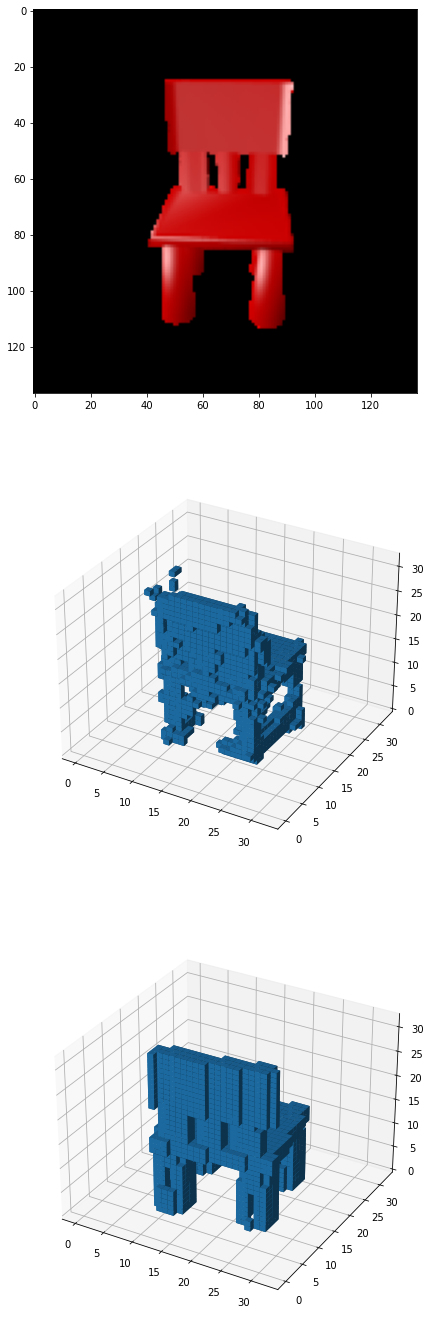

In [95]:
ax1 = plt.subplot(311)
ax2 = plt.subplot(312, projection='3d')
ax3 = plt.subplot(313, projection='3d')

ax1.imshow(image)

ax2.voxels(pred_bin_vox)

ax3.voxels(gt_vox)
plt.rcParams['figure.figsize'] = [36, 24]
plt.show()

In [96]:
idx = 23
image = test_image[idx].permute((1,2,0))
gt_vox = test_label[idx].squeeze(dim=0)
pred_vox = model(test_image[idx].unsqueeze(dim=0).cuda())
pred_bin_vox = transform_bin_vox(pred_vox.squeeze(dim=0).squeeze(dim=0), beta=0.8)

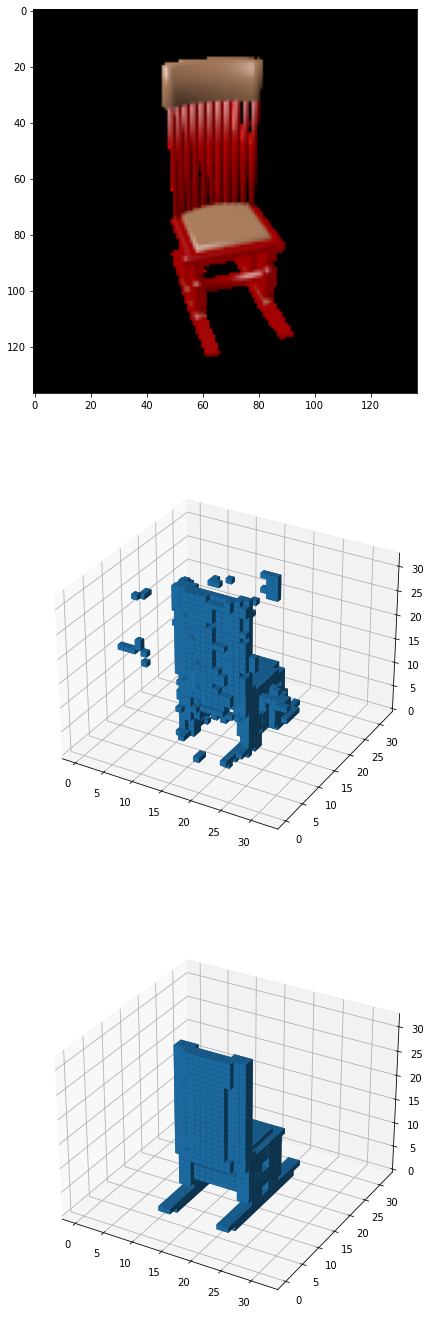

In [97]:
ax1 = plt.subplot(311)
ax2 = plt.subplot(312, projection='3d')
ax3 = plt.subplot(313, projection='3d')

ax1.imshow(image)

ax2.voxels(pred_bin_vox)

ax3.voxels(gt_vox)
plt.rcParams['figure.figsize'] = [36, 24]
plt.show()

In [102]:
idx = 39
image = test_image[idx].permute((1,2,0))
gt_vox = test_label[idx].squeeze(dim=0)
pred_vox = model(test_image[idx].unsqueeze(dim=0).cuda())
pred_bin_vox = transform_bin_vox(pred_vox.squeeze(dim=0).squeeze(dim=0), beta=0.8)

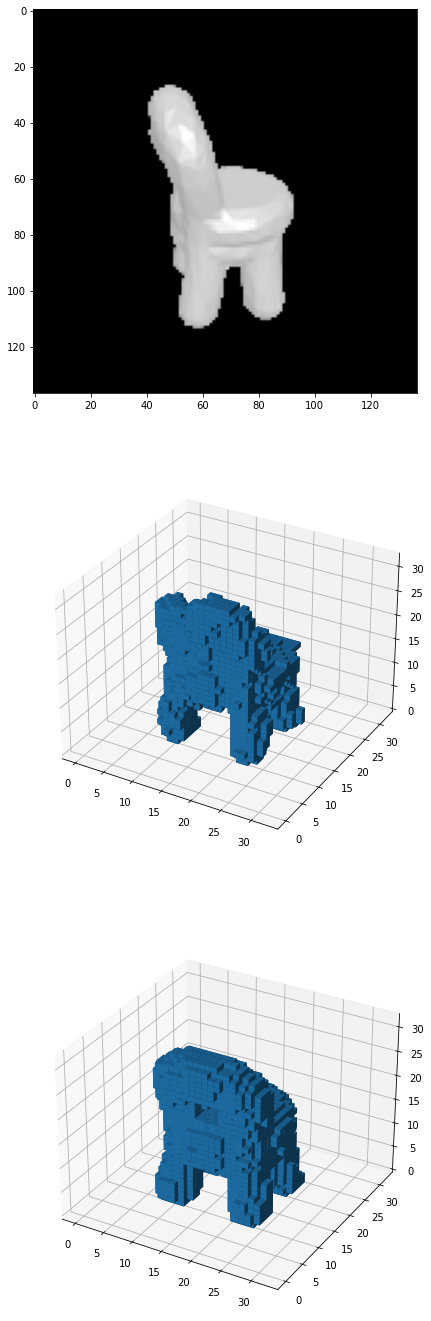

In [103]:
ax1 = plt.subplot(311)
ax2 = plt.subplot(312, projection='3d')
ax3 = plt.subplot(313, projection='3d')

ax1.imshow(image)

ax2.voxels(pred_bin_vox)

ax3.voxels(gt_vox)
plt.rcParams['figure.figsize'] = [36, 24]
plt.show()

In [107]:
idx = 62
image = test_image[idx].permute((1,2,0))
gt_vox = test_label[idx].squeeze(dim=0)
pred_vox = model(test_image[idx].unsqueeze(dim=0).cuda())
pred_bin_vox = transform_bin_vox(pred_vox.squeeze(dim=0).squeeze(dim=0), beta=0.8)

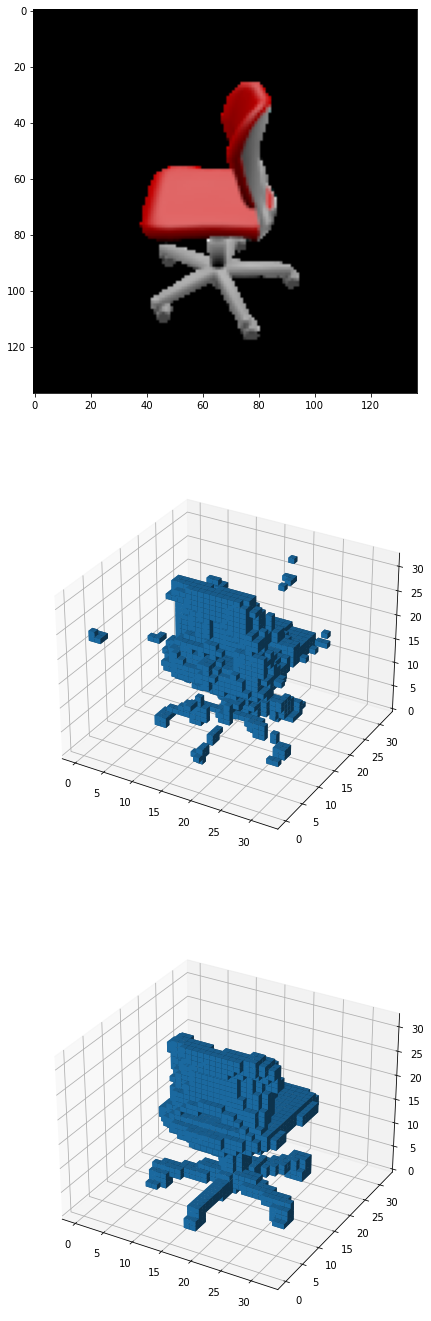

In [108]:
ax1 = plt.subplot(311)
ax2 = plt.subplot(312, projection='3d')
ax3 = plt.subplot(313, projection='3d')

ax1.imshow(image)

ax2.voxels(pred_bin_vox)

ax3.voxels(gt_vox)
plt.rcParams['figure.figsize'] = [36, 24]
plt.show()

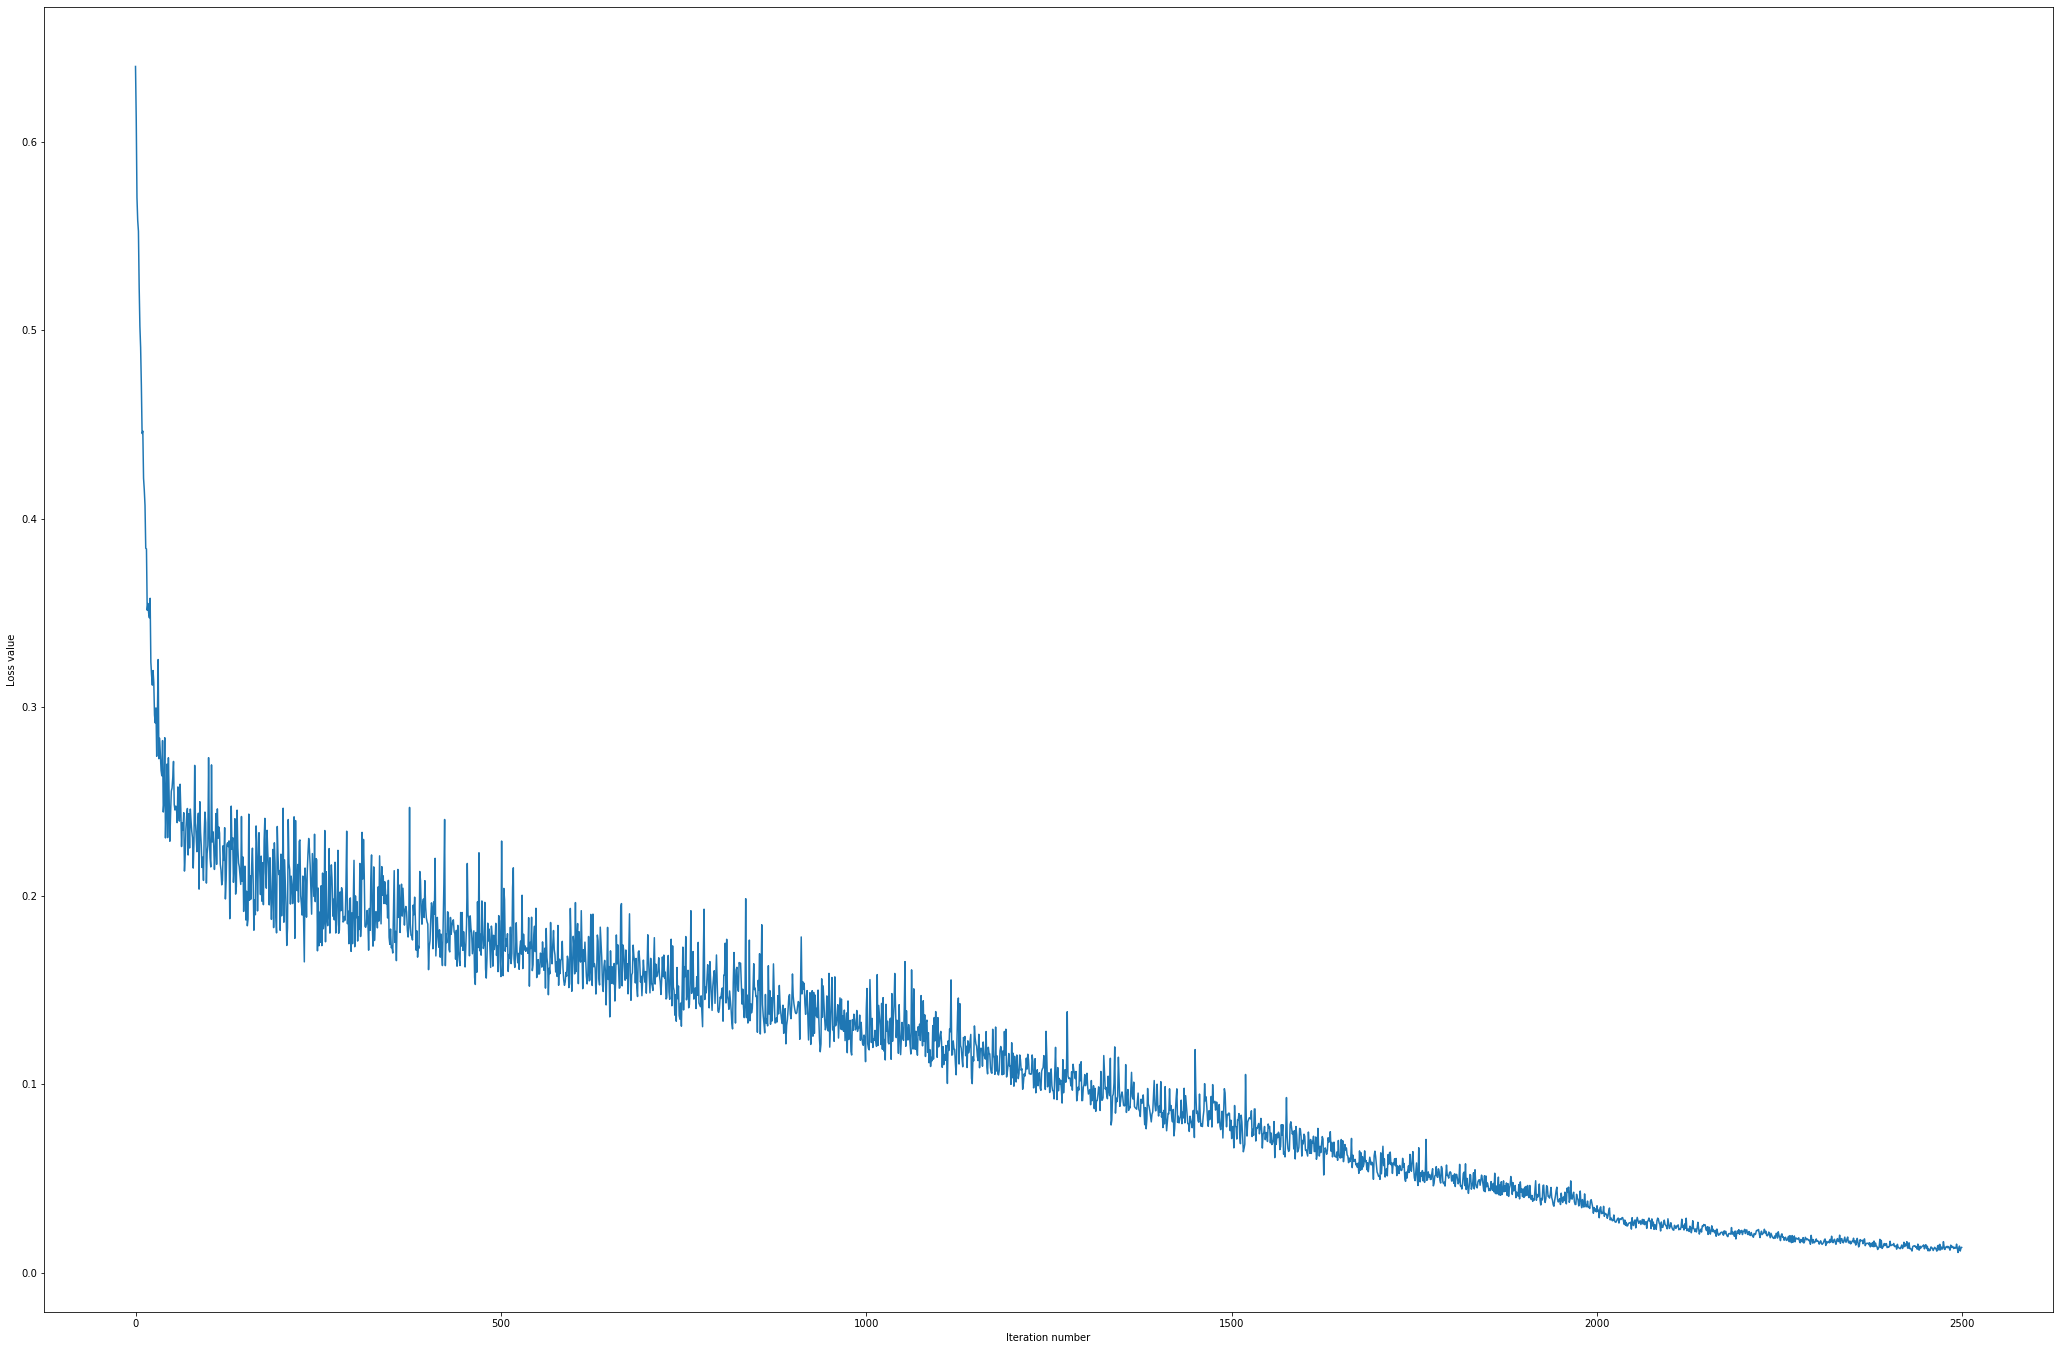

In [109]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()